# SVM - Confusion Matrix


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt 
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression

## Loading the dataset

In [2]:
# Read in the dataset
pd.set_option('display.max_columns', 50)
df = pd.read_csv('shortenedorbit.csv', low_memory=False)
#df = df.drop(columns=df.columns[0], axis=1)
df = df.drop(['Name', 'Arc_years', 'Number','Computer', 'Last_obs', 'Principal_desig',
              'Other_desigs','Ref', 'Hex_flags', 'U'],axis='columns')

df['Perturbers'] = df['Perturbers'].fillna('No_Coarse')
df['Perturbers_2'] = df['Perturbers_2'].fillna('No_Precise')

df = df.drop(df[df['Orbit_type'] == 'MBA'].sample(frac=.5).index)

possibleLabels = df.Orbit_type.value_counts()
labeldummies = pd.get_dummies(df.Orbit_type)
pert1dummies = pd.get_dummies(df.Perturbers)
pert2dummies = pd.get_dummies(df.Perturbers_2)
df = pd.concat([pert1dummies,pert2dummies,df],axis='columns')

df = df.drop(['Perturbers'],axis='columns')
df = df.drop(['Perturbers_2'],axis='columns')
df = df.fillna(0)
df.head()

,M-h,M-v,No_Coarse,38h,3Eh,3Ek,No_Precise,NEO_flag,One_km_NEO_flag,PHA_flag,H,G,Num_obs,rms,Epoch,M,Peri,Node,i,e,n,a,Num_opps,Tp,Orbital_period,Perihelion_dist,Aphelion_dist,Semilatus_rectum,Synodic_period,Orbit_type
2,0,1,0,1,0,0,0,0.0,0.0,0.0,16.80,0.15,171.0,0.32,2459200.5,14.03074,202.06597,152.13493,14.20004,0.221219,0.215091,2.758806,10,2.459135e+06,4.582282,2.148507,3.369106,1.311898,1.279152,MBA
3,0,1,0,1,0,0,0,0.0,0.0,0.0,17.00,0.15,116.0,0.25,2459200.5,226.30053,147.59857,170.66127,13.29714,0.059035,0.220231,2.715714,11,2.459808e+06,4.475341,2.555393,2.876036,1.353125,1.287742,MBA
4,0,1,0,1,0,0,0,0.0,0.0,0.0,17.80,0.15,156.0,0.30,2459200.5,10.21045,269.35576,100.74790,3.18772,0.219200,0.271569,2.361652,6,2.459163e+06,3.629309,1.843977,2.879327,1.124089,1.380328,MBA
5,0,1,0,0,0,1,0,0.0,0.0,0.0,17.79,0.15,211.0,0.55,2459200.5,303.21970,180.59257,189.65732,5.43086,0.182016,0.284133,2.291511,10,2.459400e+06,3.468830,1.874419,2.708603,1.107797,1.405050,MBA
6,0,1,0,1,0,0,0,0.0,0.0,0.0,16.40,0.15,48.0,0.32,2459200.5,59.12060,216.97141,239.56374,11.93388,0.195066,0.179229,3.115522,6,2.458871e+06,5.499160,2.507791,3.723254,1.498487,1.222264,MBA


## Preprocessing

### Splitting the data, scaling the data, and label encoding

In [3]:
le = preprocessing.LabelEncoder()
y_cm = np.unique(df['Orbit_type'])
y = df['Orbit_type']
y = le.fit_transform(y)

np.unique(y)
df = df.drop(['Orbit_type'],axis='columns')

In [4]:
X = df.iloc[:,:40].values
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [5]:
print("Shapes of data")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

Shapes of data
X_train: (1030, 29)
y_train: (1030,)
X_test: (344, 29)
y_test: (344,)


## Logistics Model

### L1/L2/No peantly

In [6]:
cvals = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100,1000]
kf = KFold(n_splits=10)

logRegNoPenalty_confmatrix = []
logRegL1_confmatrix = []
logRegL2_confmatrix = []

logRegNoPenalty_avg_confmatrix = np.zeros((10,10))
logRegL1_avg_confmatrix = np.zeros((10,10))
logRegL2_avg_confmatrix = np.zeros((10,10))

In [7]:
def logReg_conf(cval1, cval2, cval3):
    logRegNoPenalty = LogisticRegression(max_iter=1000, C= cval1, penalty= "none",  solver='saga')
    logRegL1 = LogisticRegression(max_iter=1000, C= cval2, penalty= "l1", solver='saga')
    logRegL2 = LogisticRegression(max_iter=1000, C= cval3, penalty= "l2", solver='saga')
    
    for train, test in kf.split(X_train):
        X_tr = X_train[train,:]
        y_tr = y_train[train]
        X_ts = X_train[test,:]
        y_ts = y_train[test]
        
        X_tr = preprocessing.scale(X_tr)
        X_ts = preprocessing.scale(X_ts)
        
        sm = SMOTE(k_neighbors=2)
        X_tr_smt, y_tr_smt = sm.fit_resample(X_tr, y_tr)
        
        # Linear
        logRegNoPenalty.fit(X_tr_smt,y_tr_smt)
        logRegNoPenalty_yhat_test = logRegNoPenalty.predict(X_ts) 
        
        # Poly
        logRegL1.fit(X_tr_smt,y_tr_smt)
        logRegL1_yhat_test = logRegL1.predict(X_ts) 
        
        # RBF
        logRegL2.fit(X_tr_smt,y_tr_smt)
        logRegL2_yhat_test = logRegL2.predict(X_ts) 
        
        logRegNoPenalty_confmatrix.append(np.resize(confusion_matrix(y_ts, logRegNoPenalty_yhat_test),(10,10)))
        logRegL1_confmatrix.append(np.resize(confusion_matrix(y_ts, logRegL1_yhat_test),(10,10)))
        logRegL2_confmatrix.append(np.resize(confusion_matrix(y_ts, logRegL2_yhat_test),(10,10)))

In [8]:
logReg_conf(0.1, 0.1, 0.1)

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: 

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [9]:
for (mat, mat2, mat3) in zip(logRegNoPenalty_confmatrix, logRegL1_confmatrix, logRegL2_confmatrix):
    logRegNoPenalty_avg_confmatrix = logRegNoPenalty_avg_confmatrix + mat
    logRegL1_avg_confmatrix = logRegL1_avg_confmatrix + mat2
    logRegL2_avg_confmatrix = logRegL2_avg_confmatrix + mat3

logRegNoPenalty_avg_confmatrix = logRegNoPenalty_avg_confmatrix / 9
logRegL1_avg_confmatrix = logRegL1_avg_confmatrix / 9
logRegL2_avg_confmatrix = logRegL2_avg_confmatrix / 9

In [11]:
logRegNoPenalty_avg_confmatrix

array([[ 1.55555556,  0.44444444,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.11111111,  0.11111111,  0.        ],
       [ 0.88888889,  1.22222222,  0.11111111,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.11111111,  0.        ],
       [ 0.33333333,  0.11111111,  0.        ,  0.11111111,  0.        ,
         0.22222222,  0.        ,  0.11111111,  0.44444444,  0.        ],
       [ 0.55555556,  0.        ,  0.33333333,  0.22222222,  0.        ,
         0.        ,  0.33333333,  0.        ,  0.        ,  0.        ],
       [ 1.55555556,  0.22222222,  1.55555556,  0.22222222,  2.        ,
         3.44444444,  1.66666667,  2.        ,  0.11111111,  0.        ],
       [ 0.88888889,  0.        ,  0.        ,  0.        ,  0.55555556,
         0.55555556,  0.22222222,  2.88888889,  0.55555556,  4.11111111],
       [36.        ,  2.33333333,  2.66666667,  0.44444444,  0.22222222,
         0.        ,  0.55555556,  0.        

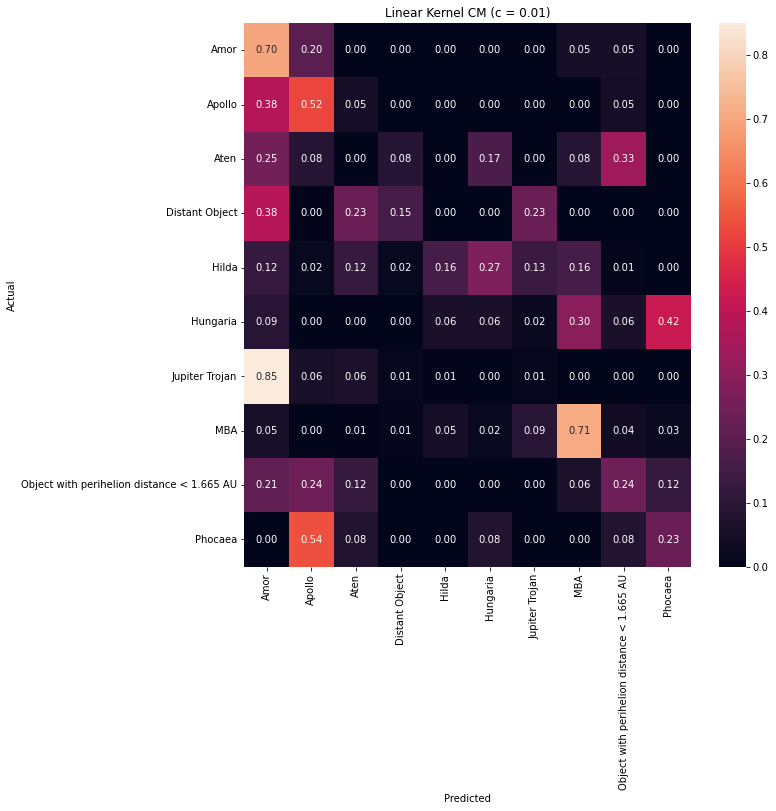

In [12]:
# Normalise
noPenaltycmn = logRegNoPenalty_avg_confmatrix.astype('float') / logRegNoPenalty_avg_confmatrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(noPenaltycmn, annot=True, fmt='.2f', xticklabels=y_cm, yticklabels=y_cm)
plt.title("Linear Kernel CM (c = 0.01)") 
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('Linear Confusion Matrix')
plt.show(block=False)

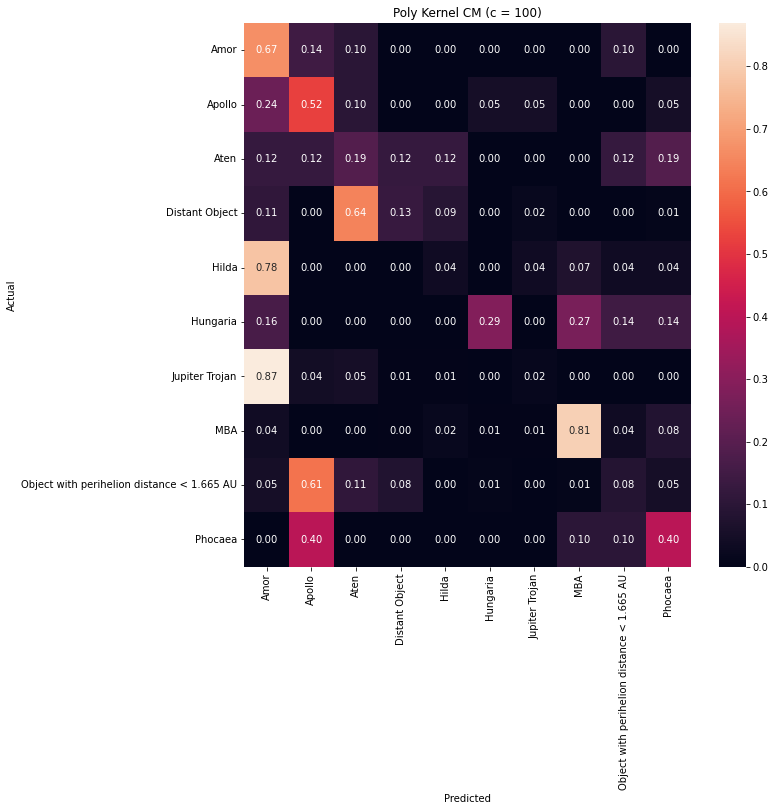

In [13]:
L1cmn = logRegL1_avg_confmatrix.astype('float') / logRegL1_avg_confmatrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(L1cmn, annot=True, fmt='.2f', xticklabels=y_cm, yticklabels=y_cm)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Poly Kernel CM (c = 100)") 
plt.savefig('Polynomial Confusion Matrix')
plt.show(block=False)

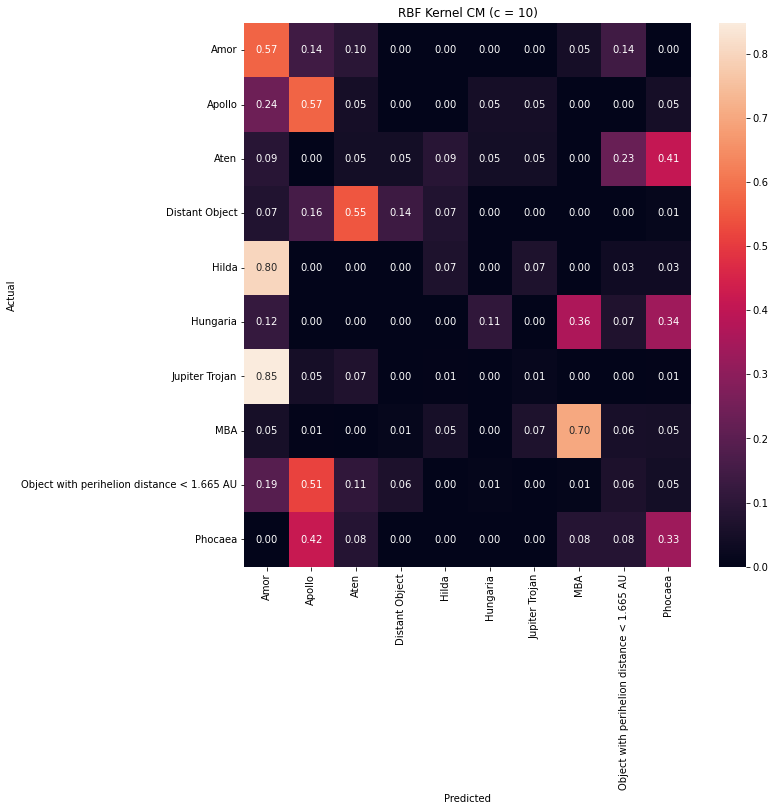

In [14]:
L2cmn = logRegL2_avg_confmatrix.astype('float') / logRegL2_avg_confmatrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(L2cmn, annot=True, fmt='.2f', xticklabels=y_cm, yticklabels=y_cm)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("RBF Kernel CM (c = 10)") 
plt.savefig('RBF Confusion Matrix')
plt.show(block=False)